## Libraries

In [144]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_squared_error

Train dates      : 1991-07-01 00:00:00 --- 2004-01-01 00:00:00  (n=151)
Validation dates : 2004-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=53)


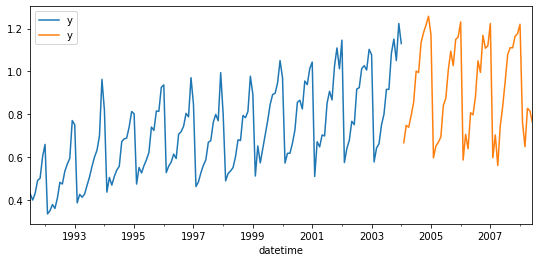

In [120]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2004-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
plt.show();

In [121]:
# Modify data_train
# ==============================================================================
np.random.seed(123)
idx_random = np.random.randint(0, len(data.loc[:end_train]), size=10)
idx_random

array([109, 126,  66,  98,  17,  83, 106, 123,  57,  96])

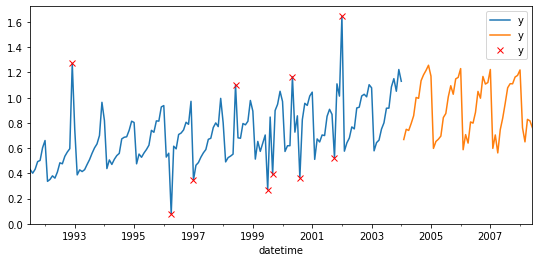

In [122]:
data.iloc[idx_random, 0] = [x+np.random.choice([0.5, -0.5]) for x in data.iloc[idx_random, 0]]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax)
data.loc[end_train:].plot(ax=ax)
data.iloc[idx_random].plot(ax=ax, c='red', style='x')
plt.show();

In [123]:
# huber

In [148]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(random_state=123),
                    lags      = 15
                )

forecaster.fit(y=data.loc[:end_train, 'y'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2004-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-04-23 13:43:39 
Last fit date: 2022-04-23 13:43:39 
Skforecast version: 0.4.3 

In [149]:
# Prediction error
# ==============================================================================
predictions = forecaster.predict(steps=53)

error_mse = mean_squared_error(
                y_true = data.loc[end_train:, 'y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.01676027252542984


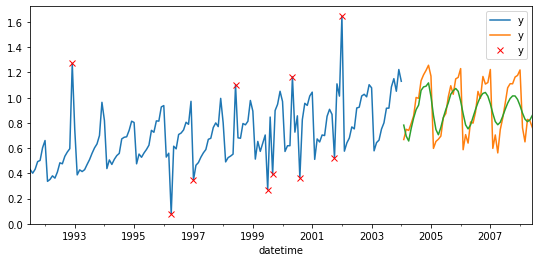

In [150]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax)
data.loc[end_train:].plot(ax=ax)
data.iloc[idx_random].plot(ax=ax, c='red', style='x')
predictions.plot(ax=ax)
plt.show();

In [151]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(random_state=123),
                lags      = 15 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = None


# Regressor hyperparameters
param_grid = {'alpha': np.logspace(-5, 2, 10)}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:, 'y'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 10


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 0.009342472295662449



In [152]:
results_grid

,lags,params,metric,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1e-05},0.009342,0.000010
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 5.994842503189409e-05},0.009343,0.000060
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.00035938136638046257},0.009343,0.000359
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.0021544346900318843},0.009344,0.002154
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01291549665014884},0.009352,0.012915
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.0774263682681127},0.009403,0.077426
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.4641588833612782},0.009723,0.464159
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 2.782559402207126},0.011945,2.782559
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 16.68100537200059},0.025279,16.681005
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 100.0},0.053698,100.000000


In [153]:
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 12,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 151
Number of observations used for backtesting: 53
    Number of folds: 5
    Number of steps per fold: 12
    Last fold only includes 5 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2004-01-01 00:00:00
    Validation: 2004-02-01 00:00:00 -- 2005-01-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2005-01-01 00:00:00
    Validation: 2005-02-01 00:00:00 -- 2006-01-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2006-01-01 00:00:00
    Validation: 2006-02-01 00:00:00 -- 2007-01-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2007-01-01 00:00:00
    Validation: 2007-02-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2008-01-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Backte

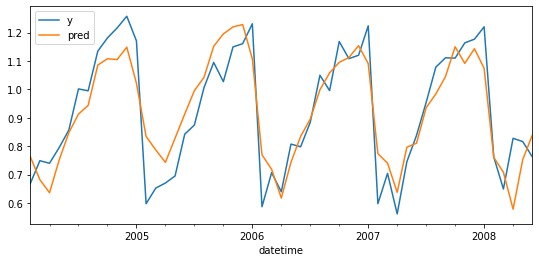

In [154]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[end_train:, 'y'].plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();

## Robust

In [137]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = HuberRegressor(),
                    lags      = 15
                )

forecaster.fit(y=data.loc[:end_train, 'y'])
forecaster

ForecasterAutoreg 
Regressor: HuberRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2004-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.0001, 'epsilon': 1.35, 'fit_intercept': True, 'max_iter': 100, 'tol': 1e-05, 'warm_start': False} 
Creation date: 2022-04-23 13:42:03 
Last fit date: 2022-04-23 13:42:03 
Skforecast version: 0.4.3 

In [138]:
# Prediction error
# ==============================================================================
predictions = forecaster.predict(steps=53)

error_mse = mean_squared_error(
                y_true = data.loc[end_train:, 'y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0138743060608108


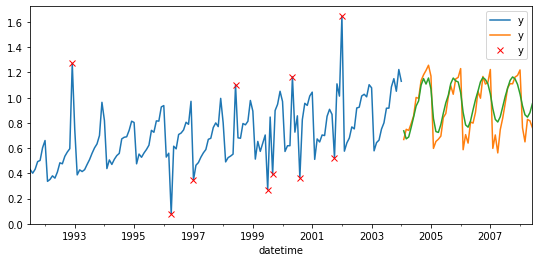

In [139]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax)
data.loc[end_train:].plot(ax=ax)
data.iloc[idx_random].plot(ax=ax, c='red', style='x')
predictions.plot(ax=ax)
plt.show();

In [141]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = HuberRegressor(max_iter=1000),
                lags      = 15 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = None


# Regressor hyperparameters
param_grid = {'epsilon': [1.0, 1.30, 1.35, 1.40, 2.]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:, 'y'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 5


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
  Parameters: {'epsilon': 1.3}
  Backtesting metric: 0.008274866040120413



In [142]:
results_grid

,lags,params,metric,epsilon
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'epsilon': 1.3},0.008275,1.30
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'epsilon': 1.35},0.008366,1.35
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'epsilon': 1.4},0.008434,1.40
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'epsilon': 1.0},0.008829,1.00
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'epsilon': 2.0},0.009179,2.00


In [147]:
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 12,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 151
Number of observations used for backtesting: 53
    Number of folds: 5
    Number of steps per fold: 12
    Last fold only includes 5 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2004-01-01 00:00:00
    Validation: 2004-02-01 00:00:00 -- 2005-01-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2005-01-01 00:00:00
    Validation: 2005-02-01 00:00:00 -- 2006-01-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2006-01-01 00:00:00
    Validation: 2006-02-01 00:00:00 -- 2007-01-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2007-01-01 00:00:00
    Validation: 2007-02-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2008-01-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Backte

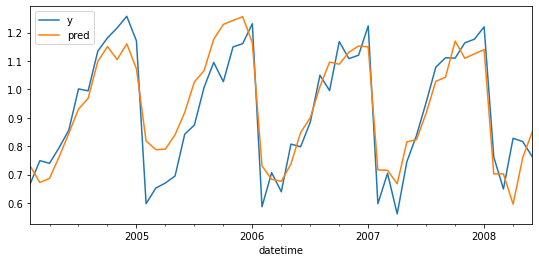

In [146]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[end_train:, 'y'].plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();